# Federated Learning with FedAvg and PySyft

This project demonstrates Federated Learning using the **FedAvg** algorithm while preserving data privacy with **PySyft**.  
The **MNIST** dataset is split arbitrarily between two datasites, each hosting its own shard of the data.

- Each datasite trains a local logistic regression model on its private MNIST split.  
- A central process aggregates the local model parameters using FedAvg over several federated rounds.  
- No raw data ever leaves the datasites, only model parameters are shared.

---

Make sure the launch the datasites and download dependencies before-hand.
Run on your terminal: 
```
python launch_datasites.py
```

We start by importing important libraries, check out **downloads.py** to know the details of the versions used.

In [1]:
import syft as sy
from syft.service.policy.policy import MixedInputPolicy

In [2]:
from datasites import DATASITE_URLS

We login in both servers as guest clients.

In [3]:
for name, url in DATASITE_URLS.items():
    print("Trying", name, url)
    c = sy.login(url=url, email="researcher@openmined.org", password="****")

Trying MNIST Part 1 http://localhost:54879
Logged into <MNIST Part 1: High side Datasite> as <researcher@openmined.org>
Trying MNIST Part 2 http://localhost:54880
Logged into <MNIST Part 2: High side Datasite> as <researcher@openmined.org>


In [4]:
datasites = {}
for name, url in DATASITE_URLS.items():
    datasites[name] = sy.login(url=url, email="researcher@openmined.org", password="****")


print(datasites.keys())

Logged into <MNIST Part 1: High side Datasite> as <researcher@openmined.org>
Logged into <MNIST Part 2: High side Datasite> as <researcher@openmined.org>
dict_keys(['MNIST Part 1', 'MNIST Part 2'])


In [5]:
mock_data = datasites["MNIST Part 1"].datasets["MNIST Dataset"]\
    .assets["MNIST Data"].mock


## The Machine Learning experiment function
The function runs locally on each datasite. It takes the site’s private dataset (and optionally the current global model parameters), trains a logistic regression model, computes local performance metrics (train/test accuracy and confusion matrix), and returns both the metrics and the updated model parameters. These parameters are then aggregated across datasites using the FedAvg algorithm to update the global model.

In [6]:
def ml_experiment(data, global_params=None, seed: int = 12345):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, confusion_matrix
    import numpy as np
    import torch as th

    X, y = data

    if X.ndim == 4:
        X = X.reshape(X.shape[0], -1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(max_iter=1000, random_state=seed)

    
    model.fit(X_train[: min(5, len(X_train))], y_train[: min(5, len(y_train))])

    if global_params is not None:
        model.coef_ = global_params["coef"].copy()
        model.intercept_ = global_params["intercept"].copy()

   
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    cm_test = confusion_matrix(y_test, y_pred_test)

    metrics = (
        {"acc": acc_train},
        {"acc": acc_test, "cm": cm_test},
    )

    params = {
        "coef": model.coef_.copy(),
        "intercept": model.intercept_.copy(),
    }

    return metrics, params

In [7]:
from syft.service.policy.policy import MixedInputPolicy

for name, datasite in datasites.items():
    data_asset = datasite.datasets["MNIST Dataset"].assets["MNIST Data"]

    simple_experiment = sy.syft_function(
        input_policy=MixedInputPolicy(
            client=datasite,
            data=data_asset,  
            seed=int,
        )
    )(ml_experiment)

    project = sy.Project(
        name=f"Simple MNIST experiment - {name}",
        description="Logistic regression on MNIST split",
        members=[datasite],
    )

    project.create_code_request(simple_experiment, datasite)
    project = project.send()


SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [8]:
datasite = datasites["MNIST Part 1"]
data_asset = datasite.datasets["MNIST Dataset"].assets["MNIST Data"]

acc_train, acc_test = datasite.code.ml_experiment(
    data=data_asset,
    seed=12345,
).get_from(datasite)

print("MNIST Part 1:", acc_train, acc_test)


MNIST Part 1: ({'acc': 0.9670222222222222}, {'acc': 0.8924, 'cm': array([[705,   0,   8,   0,   4,  15,   9,   3,   1,   1],
       [  0, 806,   5,   6,   2,   7,   1,   1,   9,   1],
       [ 10,   4, 646,   9,   6,   9,  20,  12,  24,   3],
       [  7,   7,  21, 647,   4,  28,   4,  10,  20,  12],
       [  8,   4,  10,   1, 665,   2,  22,   4,   9,  29],
       [ 10,   2,   7,  22,  14, 566,  17,   2,  14,  15],
       [  5,   4,  16,   0,  12,  16, 676,   1,   1,   1],
       [  1,   2,  14,   7,  12,   2,   0, 703,   2,  40],
       [ 11,  12,  14,  18,   3,  30,   9,   1, 618,  16],
       [  3,   7,   2,   9,  22,   4,   0,  24,  11, 661]], dtype=int64)}) {'coef': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'intercept': array([-3.16721403, -6.60854163,  4.09357259,  3.41559334, -2.31

## The federated Learning FedAvg function 

In [12]:
from collections import defaultdict
import numpy as np

def avg_params(all_params: list[dict]) -> dict:
    return {
        "intercept": np.mean([p["intercept"] for p in all_params], axis=0),
        "coef": np.mean([p["coef"] for p in all_params], axis=0),
    }

def fl_experiment_logreg_true(
    datasites: dict,
    fl_epochs: int = 5,
    seed: int = 12345,
):
    fl_metrics = defaultdict(list)
    fl_model_params = None 

    for epoch in range(fl_epochs):
        print(f"\n=== FL epoch {epoch+1}/{fl_epochs} ===")

        epoch_params = []

        for name, ds in datasites.items():
            data_asset = ds.datasets["MNIST Dataset"].assets["MNIST Data"]

           
            metrics, params = ds.code.ml_experiment(
                data=data_asset,
                global_params=fl_model_params,
                seed=seed + epoch,
            ).get_from(ds)

            train_metrics, test_metrics = metrics
            acc_train = train_metrics["acc"]
            acc_test = test_metrics["acc"]
            print(f"  {name} -> train={acc_train:.4f}, test={acc_test:.4f}")

            fl_metrics[epoch].append((metrics, params))
            epoch_params.append(params)

        # FedAvg: this is exactly where the magic is happening
        fl_model_params = avg_params(epoch_params)
        print(
            f"  FedAvg epoch {epoch+1}: "
            f"intercept shape={fl_model_params['intercept'].shape}, "
            f"coef shape={fl_model_params['coef'].shape}"
        )

    return fl_metrics, fl_model_params


In [14]:
fl_metrics ,fl_model_params= fl_experiment_logreg_true(datasites, fl_epochs=5, seed=12345)


=== FL epoch 1/5 ===
  MNIST Part 1 -> train=0.9670, test=0.8924
  MNIST Part 2 -> train=0.9674, test=0.8916
  FedAvg epoch 1: intercept shape=(10,), coef shape=(10, 784)

=== FL epoch 2/5 ===
  MNIST Part 1 -> train=0.9691, test=0.8900
  MNIST Part 2 -> train=0.9689, test=0.8951
  FedAvg epoch 2: intercept shape=(10,), coef shape=(10, 784)

=== FL epoch 3/5 ===
  MNIST Part 1 -> train=0.9650, test=0.9004
  MNIST Part 2 -> train=0.9683, test=0.8983
  FedAvg epoch 3: intercept shape=(10,), coef shape=(10, 784)

=== FL epoch 4/5 ===
  MNIST Part 1 -> train=0.9668, test=0.8857
  MNIST Part 2 -> train=0.9708, test=0.8888
  FedAvg epoch 4: intercept shape=(10,), coef shape=(10, 784)

=== FL epoch 5/5 ===
  MNIST Part 1 -> train=0.9672, test=0.8983
  MNIST Part 2 -> train=0.9670, test=0.8963
  FedAvg epoch 5: intercept shape=(10,), coef shape=(10, 784)


In [15]:
fl_metrics

defaultdict(list,
            {0: [(({'acc': 0.9670222222222222},
                {'acc': 0.8924,
                 'cm': array([[705,   0,   8,   0,   4,  15,   9,   3,   1,   1],
                        [  0, 806,   5,   6,   2,   7,   1,   1,   9,   1],
                        [ 10,   4, 646,   9,   6,   9,  20,  12,  24,   3],
                        [  7,   7,  21, 647,   4,  28,   4,  10,  20,  12],
                        [  8,   4,  10,   1, 665,   2,  22,   4,   9,  29],
                        [ 10,   2,   7,  22,  14, 566,  17,   2,  14,  15],
                        [  5,   4,  16,   0,  12,  16, 676,   1,   1,   1],
                        [  1,   2,  14,   7,  12,   2,   0, 703,   2,  40],
                        [ 11,  12,  14,  18,   3,  30,   9,   1, 618,  16],
                        [  3,   7,   2,   9,  22,   4,   0,  24,  11, 661]], dtype=int64)}),
               {'coef': array([[0., 0., 0., ..., 0., 0., 0.],
                       [0., 0., 0., ..., 0., 0., 0.],
   

In [16]:
fl_model_params

{'intercept': array([-3.29316561, -6.28735931,  3.34034989,  4.16840761, -1.97265293,
         4.28241647, -2.91834912, -3.72749186,  5.73707731,  0.67076755]),
 'coef': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

## Plots (accuracy and confusion matrix)

In [17]:
from matplotlib import pyplot as plt
import numpy as np

def plot_fl_metrics(datasites, fl_metrics, title="FL Experiment"):
    site_names = list(datasites.keys())
    n_epochs = len(fl_metrics)

    mean_test_acc_per_epoch = []

    for epoch in range(n_epochs):
        epoch_test_accs = []
        for ((train_m, test_m), params) in fl_metrics[epoch]:
            epoch_test_accs.append(test_m["acc"])
        mean_test_acc_per_epoch.append(np.mean(epoch_test_accs))

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, n_epochs + 1), mean_test_acc_per_epoch, marker="o")
    plt.xlabel("FL epoch")
    plt.ylabel("Mean test accuracy")
    plt.title(title)
    plt.grid(True)


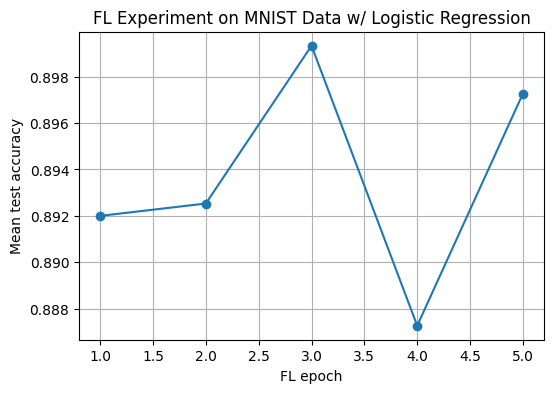

In [18]:
plot_fl_metrics(datasites, fl_metrics, title="FL Experiment on MNIST Data w/ Logistic Regression")
plt.show()


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

def plot_all_confusion_matrices(confusion_matrices, title="Confusion Matrices"):
    """
    confusion_matrices: dict {site_name: cm_array}
    """
    n_sites = len(confusion_matrices)
    n_cols = min(3, n_sites)
    n_rows = int(np.ceil(n_sites / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (site_name, cm) in zip(axes, confusion_matrices.items()):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(site_name)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    for ax in axes[len(confusion_matrices):]:
        ax.axis("off")

    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


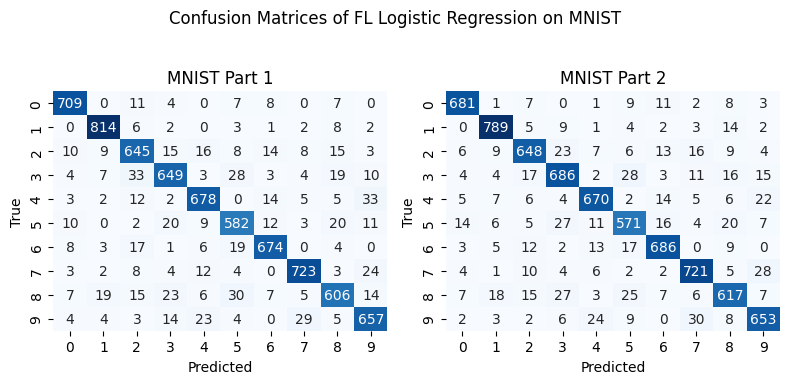

In [20]:
from matplotlib import pyplot as plt

last_epoch = sorted(fl_metrics)[-1]
confusion_matrices = {
    name: fl_metrics[last_epoch][idx][0][1]["cm"]
    for idx, name in enumerate(datasites)
}

plot_all_confusion_matrices(
    confusion_matrices,
    title="Confusion Matrices of FL Logistic Regression on MNIST",
)
plt.show()


In [23]:
def plot_site_accuracies(datasites, fl_metrics, title="Per-site test accuracy per FL round"):
    epochs = sorted(fl_metrics.keys())
    plt.figure(figsize=(6, 4))

    for site_idx, name in enumerate(datasites.keys()):
        site_accs = []
        for e in epochs:
            (train_m, test_m), params = fl_metrics[e][site_idx]
            site_accs.append(test_m["acc"])
        plt.plot(epochs, site_accs, marker="o", label=name)

    plt.xlabel("FL round")
    plt.ylabel("Test accuracy")
    plt.title(title)
    plt.grid(True)
    plt.legend()


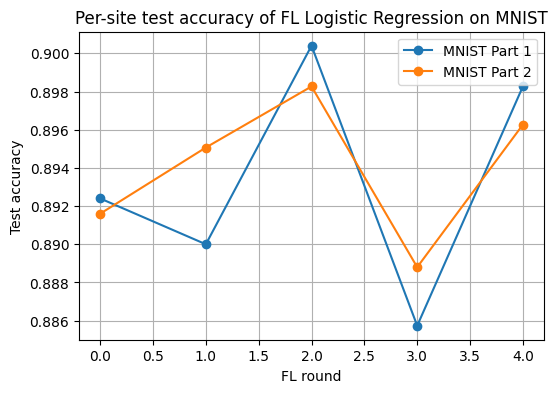

In [24]:
plot_site_accuracies(datasites, fl_metrics, title="Per-site test accuracy of FL Logistic Regression on MNIST")
plt.show()


## Conclusion 
